## Setup

In [42]:
import pandas as pd
import numpy as np
import random
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier

# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/My\ Drive/Colab\ Notebooks/files/cs5691

## Utilities

In [2]:
# function to calculate penrose inverse of a matrix
def pinv(A, alpha=0, tikhonov=False, phi_t=None): 
    Ah = np.asmatrix(A).getH()
    if(not tikhonov):
        return np.matmul(inv(np.matmul(Ah,A)+alpha*np.eye(A.shape[1])),Ah)
    else:
        return np.matmul(inv(np.matmul(Ah,A)+alpha*phi_t),Ah)

# function to split the dataset into Training data Test data
def train_test_split(X,Y,N):
    shuffle = np.random.permutation(N)
    X_train = X[:int(0.9*N)]; Y_train = Y[:int(0.9*N)]
    # X_cs = X[int(0.7*N):int(0.9*N)]; Y_cs = Y[int(0.7*N):int(0.9*N)]
    X_test = X[int(0.9*N):N]; Y_test = Y[int(0.9*N):N]
    return X_train, Y_train, X_test, Y_test   

# function to plot 1D data
def plot_1d(x_train, y_train, x, y, ptitle):
    plt.grid()
    plt.title(ptitle)  
    plt.xlabel('x'); plt.ylabel('y')
    plt.scatter(x_train, y_train, facecolors='none', edgecolors='red', s=50)
    plt.ylim(-1,13)
    plt.plot(x, y)

# function to calculate Erms for 1D data    
def Erms_1d(w, x, y):
    y_pred = np.zeros(y.shape)
    for i in range(w.shape[0]):
        y_pred = y_pred + w[i,0]*(x**i)
    return np.mean((y_pred-y)**2)**0.5

# polynomial fit for 1D data
def polynomial_fit_1d(deg, x_train, y_train, rlambda=0):
    design_matrix = np.ones((x_train.shape[0],1))
    for i in range(deg):
        design_matrix = np.c_[design_matrix, x_train**(i+1)]
    w = np.matmul(pinv(design_matrix, alpha=rlambda), y_train)
    x_plot = np.linspace(-2, 2, 1000).reshape((1000,1))
    y_plot = w[0,0]*np.ones((1000,1))
    for i in range(1,deg+1,1):
        y_plot = y_plot + w[i,0]*(x_plot**i)
    return w, x_plot, y_plot

# polynomial fit for 2D data
def polynomial_fit_2d(deg, x_train, y_train, rlambda=0):
    design_matrix = np.ones((x_train.shape[0],1))
    for i in range(1,deg+1,1):
        for j in range(i+1):
            design_matrix = np.c_[design_matrix, (x_train[:,0]**j)*(x_train[:,1]**(i-j))]
    w = np.matmul(pinv(design_matrix, alpha=rlambda), y_train)
    x1 = np.linspace(-14, 14, 100)
    x2 = np.linspace(-14, 14, 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = w[0,0]*np.ones(x1.shape)
    for i in range(1,deg+1,1):
        for j in range(i+1):
            ind = ((i+1)*i)//2 + j
            y = y + w[ind,0]*(x1**j)*(x2**(i-j))
    return w, x1, x2, y

# function to calculate Erms for 1D data 
def Erms_2d(deg, w, x, y):
    y_pred = np.zeros(y.shape)
    for i in range(deg+1):
        for j in range(i+1):
            ind = ((i+1)*i)//2 + j
            x1 = x[:,0].reshape(y_pred.shape)
            x2 = x[:,1].reshape(y_pred.shape)
            y_pred = y_pred + w[ind,0]*(x1**j)*(x2**(i-j))
    return np.mean((y_pred-y)**2)**0.5,y_pred

#funciton to plot 2d data
def plot_2d(ax, x_train, y_train, x1, x2, y, ptitle, alpha=1):
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.set_title(ptitle, pad=20)
    surf = ax.plot_surface(x1, x2, y, alpha=0.9) 
    ax.scatter(x_train[:,0], x_train[:,1], y_train, c="red", alpha=alpha)
    ax.set_zlim(0, 22)

# function to perform k-means clustering
def kmeans(x,k,max_iter=100):
    d = x.shape[1]
    m = x.shape[0]
    randpoints = list(random.sample(range(x.shape[0]),k))
    medians = x[randpoints,:]
    clusters = np.ones(x.shape[0])

    change = 1; iter = 0
    while(change and iter<max_iter):
        clusters_new = np.apply_along_axis(lambda row : np.argmin(np.sum((medians-row)**2,1)), 1, x)
        change = np.count_nonzero(clusters-clusters_new); iter+=1
        clusters = clusters_new
        medians = np.zeros((k, d))
        for i in range(m):
            ind = clusters[i]
            medians[ind] = medians[ind] + x[i]
        for i in range(k):
            medians[i] = medians[i]/(m-np.count_nonzero(clusters-i))

    return medians, clusters
    
# Gaussian basis fit function
def gaussian_basis_fit(deg, x, y, sigma2, rlambda=0, tikhonov=False, predefined_means=None):
    means,_ = kmeans(x, deg)
    if(predefined_means is not None):
        means = predefined_means
    phi = np.ones((x.shape[0],1))
    for i in range(deg):
        phi = np.c_[phi, np.exp(-np.sum((x-means[i])**2,1)/sigma2)]
    
    if(not tikhonov):
        w = np.matmul(pinv(phi,alpha=rlambda), y)
    else:
        phi_t = np.eye(deg+1)
        for i in range(deg):
            for j in range(i):
                phi_t[i+1][j+1] = np.exp(-np.sum((means[j]-means[i])**2)/sigma2)
                phi_t[j+1][i+1] = phi_t[i+1][j+1]
        w = np.matmul(pinv(phi,alpha=rlambda, tikhonov=True, phi_t=phi_t), y)

    if(x.shape[1] <= 2):
        x1 = np.linspace(-14, 14, 100)
        x2 = np.linspace(-14, 14, 100)
        x1, x2 = np.meshgrid(x1, x2)
        y = w[0,0]*np.ones(x1.shape)
        for i in range(deg):
            y = y + w[i+1,0]*np.exp(-((x1-means[i,0])**2 + (x2-means[i,1])**2)/sigma2)
        return w, means, x1, x2, y
    return w, means

# funciton to calculate Erms for Gaussian models
def Erms_gaussian(x, y, w, means, sigma2):
    y_pred = w[0,0]*np.ones((x.shape[0],1))
    k = means.shape[0]
    for i in range(k):
        y_pred = y_pred + w[i+1,0]*(np.exp(-(np.sum((x-means[i])**2,1)/sigma2))).reshape((-1,1))
    return np.mean((y_pred-y)**2)**0.5, y_pred

# function to create k sets for k fold cross validation.
def k_cross_sets(X,Y,k=5):
    n = X.shape[0]
    x_train_sets = []; y_train_sets = []
    x_valid_sets = []; y_valid_sets = []
    ind = [i for i in range(n)]
    for i in range(k):
        x_valid_sets.append(X[int(i*(n/k)):int((i+1)*(n//k))])
        y_valid_sets.append(Y[int(i*(n/k)):int((i+1)*(n//k))])
        ind = [i for i in range(0, int(i*(n/k)), 1)] + [i for i in range(int((i+1)*(n//k)), n, 1)]
        x_train_sets.append(X[ind])
        y_train_sets.append(Y[ind])
    return x_train_sets, y_train_sets, x_valid_sets, y_valid_sets

def find_sigma(x, k):
    means, labels = kmeans(x, k)
    su = 0
    for i in range(x.shape[0]):
        su += np.sum((x[i]-means[labels[i]])**2)
    su = su/x.shape[0]
    return su

# Dataset 1

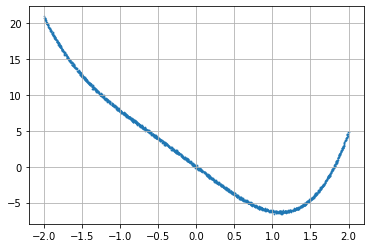

In [3]:
#reading the dataset
#and visualising the 1D dataset
df = pd.read_csv("function1.csv")[['x','y']]
X = np.array(df[['x']]); Y = np.array(df[['y']])
plt.scatter(X, Y, s=0.5); plt.grid(); plt.show()

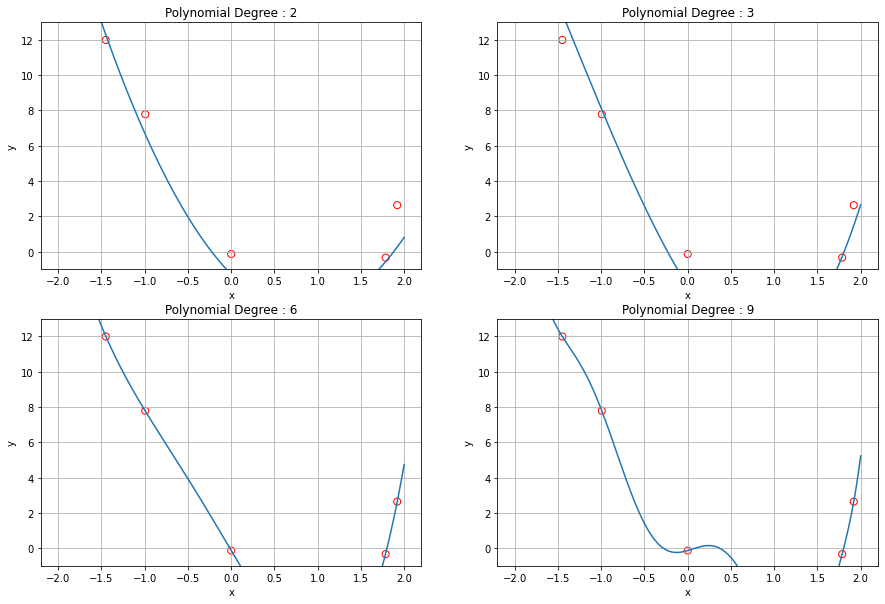

In [4]:
#creating polynomial fits with Train : Test :: 9 : 1
x_train, y_train, x_test, y_test = train_test_split(X,Y,12)
plt.figure(figsize=(15,10))
for (i,deg) in enumerate([2,3,6,9]):
    w,x,y = polynomial_fit_1d(deg, x_train, y_train)
    plt.subplot(2,2,i+1) #creates a plot with polynomial fits
    plot_1d(x_train, y_train, x, y, "Polynomial Degree : "+str(deg))
plt.show()

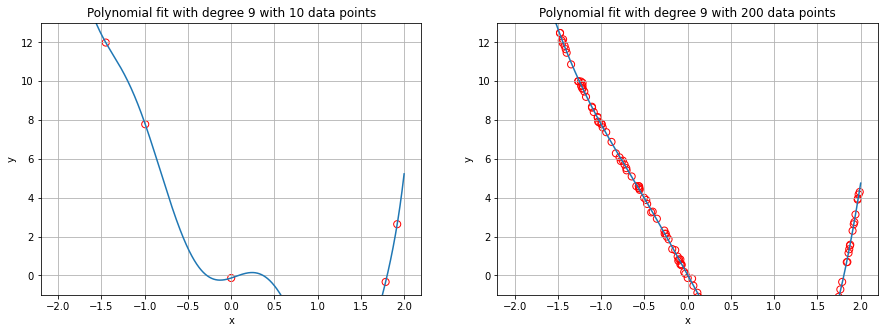

In [5]:
# creating polynomial fits for data with 
# varying number of training data points 
plt.figure(figsize=(15,5))
for (i,N) in enumerate([12,223]):
    x_train, y_train, x_test, y_test = train_test_split(X,Y,N)
    w,x,y = polynomial_fit_1d(9, x_train, y_train)
    plt.subplot(1,2,i+1)
    ptitle = "Polynomial fit with degree 9 with "+str(int(0.9*N))+" data points"
    plot_1d(x_train, y_train, x, y, ptitle)
plt.show()

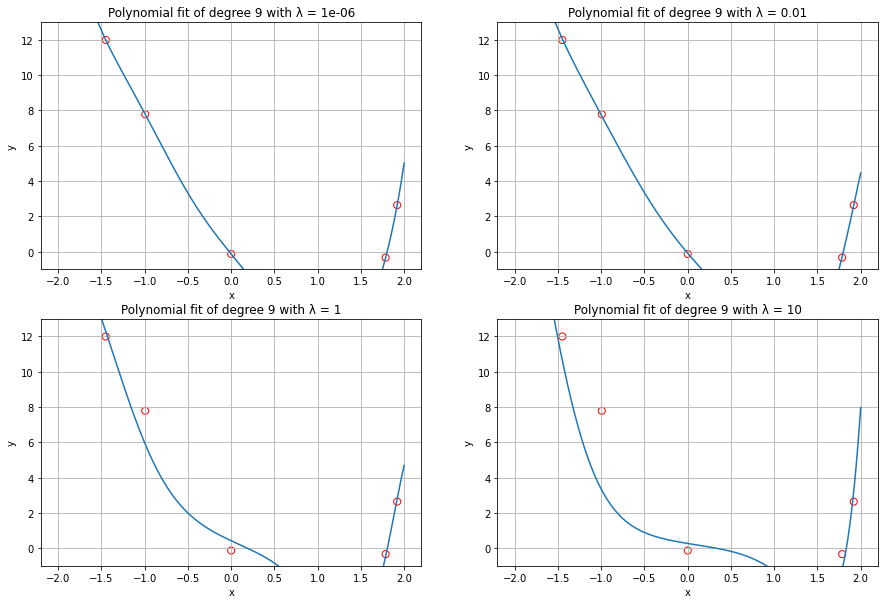

In [6]:
# Trying different values of rlambda for M = 9. 
plt.figure(figsize=(15,10))
x_train, y_train, x_test, y_test = train_test_split(X,Y,12)
for (i,rlambda) in enumerate([0.000001,0.01,1,10]):
    w,x,y = polynomial_fit_1d(9, x_train, y_train, rlambda)
    plt.subplot(2,2,i+1)
    ptitle = "Polynomial fit of degree 9 with λ = "+str(rlambda)
    plot_1d(x_train, y_train, x, y, ptitle)
plt.show()

In [7]:
# generating table containing Training , validation and Test set errors
# in a table for different values of M.
x_train, y_train, x_test, y_test = train_test_split(X,Y,1000)
df = pd.DataFrame(np.zeros((4,4)))
df = df.astype({0: 'str'})
K = 5
for (i,deg) in enumerate([2,3,6,9]):
    df.iloc[i,0] = "Polynomial Degree - "+str(deg)

    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w,x,y = polynomial_fit_1d(deg, x_train_sets[k], y_train_sets[k], rlambda=0.0001)
        train_errors.append(Erms_1d(w, x_train_sets[k], y_train_sets[k]))
        cv_errors.append(Erms_1d(w, x_valid_sets[k], y_valid_sets[k]))

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)
    df.iloc[i,3] = Erms_1d(w, x_test, y_test)

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Error,Validation Error,Test Set Error
,,,
Polynomial Degree - 2,1.589838,1.594099,1.477020
Polynomial Degree - 3,0.970063,0.979554,1.035273
Polynomial Degree - 6,0.097596,0.098702,0.102438
Polynomial Degree - 9,0.097341,0.099356,0.102343


In [8]:
# generating table containing Training , validation and Test set errors
# in a table for different values of rlambda
x_train, y_train, x_test, y_test = train_test_split(X,Y,1000)
df = pd.DataFrame(np.zeros((4,4)))
df = df.astype({0: 'str'})
K = 5
for (i,rlambda) in enumerate([0.0000001,0.001,0.01,0.1]):
    df.iloc[i,0] = "Regularization λ = "+str(rlambda)

    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w,x,y = polynomial_fit_1d(3, x_train_sets[k], y_train_sets[k], rlambda)
        train_errors.append(Erms_1d(w, x_train_sets[k], y_train_sets[k]))
        cv_errors.append(Erms_1d(w, x_valid_sets[k], y_valid_sets[k]))

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)
    df.iloc[i,3] = Erms_1d(w, x_test, y_test)

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Error,Validation Error,Test Set Error
,,,
Regularization λ = 1e-07,0.970063,0.979554,1.035274
Regularization λ = 0.001,0.970063,0.979554,1.035268
Regularization λ = 0.01,0.970063,0.979553,1.035214
Regularization λ = 0.1,0.970066,0.979549,1.034672


# Dataset 2

## Polynomial Basis Function

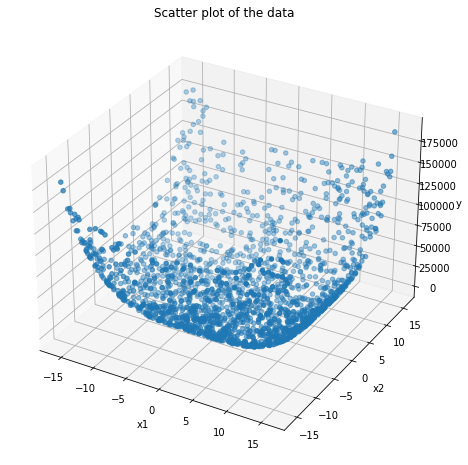

In [9]:
# Reading the 2D dataset and visualising it
df = pd.read_csv("function1_2d.csv")[['x1','x2','y']]
X = np.array(df[['x1','x2']]); Y = np.array(df[['y']])
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Scatter plot of the data")
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(X[:,0], X[:,1], Y)
plt.show()

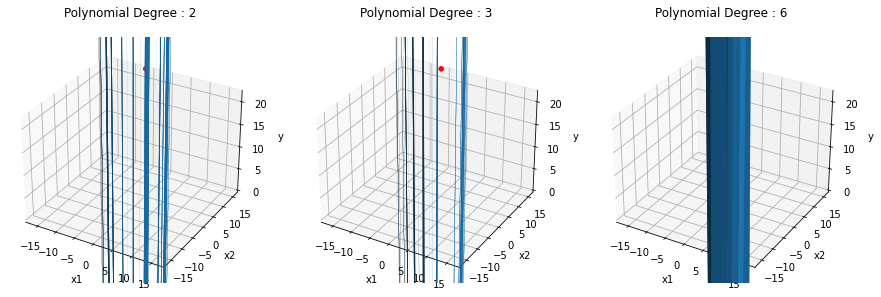

In [10]:
# creating polynomial fits with Train : Test :: 9 : 1 
x_train, y_train, x_test, y_test = train_test_split(X,Y,56)
fig = plt.figure(figsize=(15,5))
for (i,deg) in enumerate([2,3,6]):
    w,x1,x2,y = polynomial_fit_2d(deg, x_train, y_train)
    ax = fig.add_subplot(130+i+1, projection='3d')
    plot_2d(ax, x_train, y_train, x1, x2, y, "Polynomial Degree : "+str(deg))
plt.show()

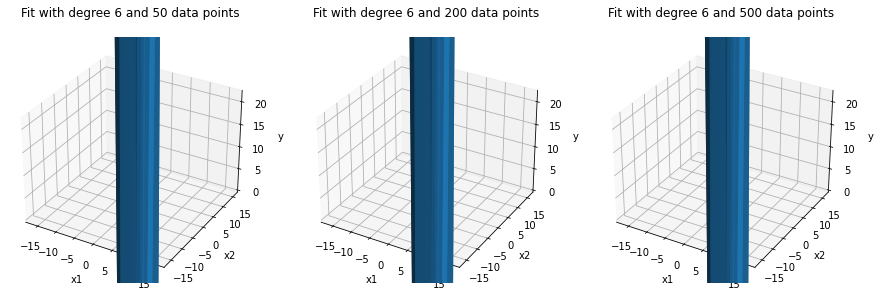

In [11]:
# creating polynomial fits for data with 
# varying number of training data points 
fig = plt.figure(figsize=(15,5))
for (i,N) in enumerate([56, 223, 556]):
    x_train, y_train, x_test, y_test = train_test_split(X,Y,N)
    w,x1,x2,y = polynomial_fit_2d(6, x_train, y_train)
    ax = fig.add_subplot(130+i+1, projection='3d')
    plot_2d(ax, x_train, y_train, x1, x2, y, "Fit with degree 6 and "+str(int(0.9*N))+" data points", alpha=0.5)
plt.show()

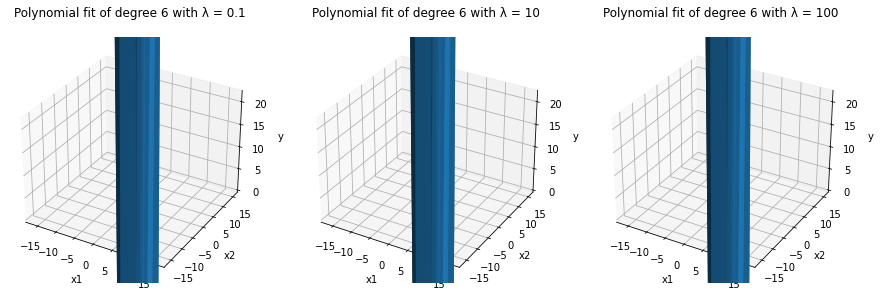

In [12]:
# Trying different values of rlambda for M = 6. 
x_train, y_train, x_test, y_test = train_test_split(X,Y,56)
fig = plt.figure(figsize=(15,5))
for (i,rlambda) in enumerate([0.1,10,100]):
    w,x1,x2,y = polynomial_fit_2d(6, x_train, y_train, rlambda)
    ax = fig.add_subplot(130+i+1, projection='3d')
    ptitle = "Polynomial fit of degree 6 with λ = "+str(rlambda)
    plot_2d(ax, x_train, y_train, x1, x2, y, ptitle, alpha=0.6)
plt.show()

In [13]:
# generating table containing Training , validation and Test set errors
# in a table for different values of M.
x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
df = pd.DataFrame(np.zeros((3,4)))
df = df.astype({0: 'str'})
K = 5
for (i,deg) in enumerate([2,3,6]):
    df.iloc[i,0] = "Polynomial Degree - "+str(deg)

    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w,x1,x2,y = polynomial_fit_2d(deg, x_train_sets[k], y_train_sets[k])
        train_errors.append(Erms_2d(deg, w, x_train_sets[k], y_train_sets[k])[0])
        cv_errors.append(Erms_2d(deg, w, x_valid_sets[k], y_valid_sets[k])[0])

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)
    w,x1,x2,y = polynomial_fit_2d(deg, x_train, y_train)
    df.iloc[i,3],_ = Erms_2d(deg, w, x_test, y_test)

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Error,Validation Error,Test Set Error
,,,
Polynomial Degree - 2,1.104285e+04,1.108108e+04,1.028138e+04
Polynomial Degree - 3,1.102386e+04,1.112565e+04,1.026024e+04
Polynomial Degree - 6,2.109410e-08,2.115987e-08,3.240833e-08


In [14]:
# generating table containing Training , validation and Test set errors
# in a table for different values of rlambda
x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
df = pd.DataFrame(np.zeros((7,4)))
df = df.astype({0: 'str'})
K = 5
for (i,rlambda) in enumerate([0.00001,0.1,1,3,5,7,10]):
    df.iloc[i,0] = "Regularization λ = "+str(rlambda)

    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w,x1,x2,y = polynomial_fit_2d(deg, x_train_sets[k], y_train_sets[k], rlambda)
        train_errors.append(Erms_2d(deg, w, x_train_sets[k], y_train_sets[k])[0])
        cv_errors.append(Erms_2d(deg, w, x_valid_sets[k], y_valid_sets[k])[0])

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)

    w,x1,x2,y = polynomial_fit_2d(deg, x_train, y_train, rlambda)
    df.iloc[i,3],_ = Erms_2d(deg, w, x_test, y_test)

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Error,Validation Error,Test Set Error
,,,
Regularization λ = 1e-05,1.639027e-08,1.659849e-08,8.934362e-09
Regularization λ = 0.1,1.744183e-07,1.779114e-07,1.289245e-07
Regularization λ = 1,1.718487e-06,1.762247e-06,1.318129e-06
Regularization λ = 3,5.128092e-06,5.262639e-06,3.956173e-06
Regularization λ = 5,8.507420e-06,8.729018e-06,6.574015e-06
Regularization λ = 7,1.185174e-05,1.215690e-05,9.180076e-06
Regularization λ = 10,1.681940e-05,1.725200e-05,1.307428e-05


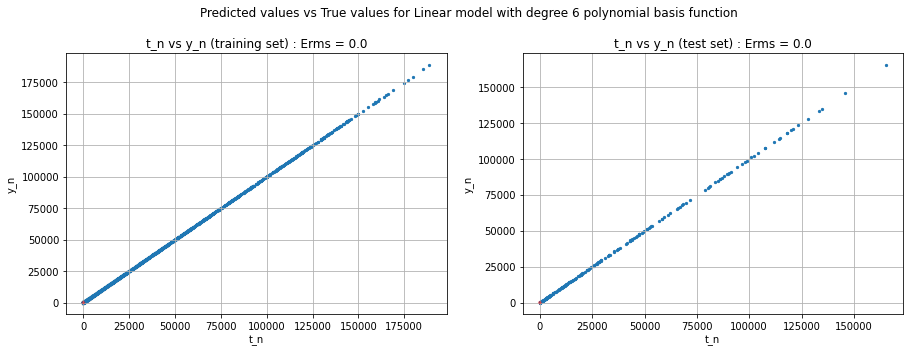

In [15]:
# Predicted values vs True values for Linear model with degree 6 polynomial basis function.
x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
w,x1,x2,y = polynomial_fit_2d(6, x_train, y_train, rlambda=5)

x_ax = np.linspace(8, 24, 200)
erms, y_pred_train = Erms_2d(6, w, x_train, y_train)
plt.figure(figsize=(15,5))
plt.suptitle("Predicted values vs True values for Linear model with degree 6 polynomial basis function ")

plt.subplot(121)
plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
plt.scatter(y_train, y_pred_train, s=5)
plt.xlabel('t_n'); plt.ylabel('y_n')
plt.title("t_n vs y_n (training set) : Erms = "+str(round(erms,3)))
plt.grid()

erms, y_pred_test = Erms_2d(6, w, x_test, y_test)
plt.subplot(122)
plt.xlabel('t_n'); plt.ylabel('y_n')
plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
plt.scatter(y_test, y_pred_test,  s=5)
plt.title("t_n vs y_n (test set) : Erms = "+str(round(erms,3)))
plt.grid()

plt.subplots_adjust(top=0.85)
plt.show()

## Gaussian Basis Model

In [40]:
# Deciding upon number of clusters to use for Gaussian Basis Model.
DF = pd.read_csv('function1_2d.csv')
#x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
x_train = x_tr500
y_train = y_tr500
x_test = x_test500
y_test = y_test500
df = pd.DataFrame(np.zeros((6,4)))
df = df.astype({0: 'str'})
sigma2 = 25
rlambda = 0
K = 5
# Using means from last cell
# means,_ = kmeans(x_train, deg)
for (i,deg) in enumerate([15,25,50,100,150,200]):
    df.iloc[i,0] = str(deg)+" clusters"

    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w, means, x1, x2, y = gaussian_basis_fit(deg, x_train_sets[k], y_train_sets[k], sigma2, rlambda, tikhonov='tikn')
        train_errors.append(Erms_gaussian(x_train_sets[k], y_train_sets[k], w, means, sigma2)[0])
        cv_errors.append(Erms_gaussian(x_valid_sets[k], y_valid_sets[k], w, means, sigma2)[0])

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)

    w, means, x1, x2, y = gaussian_basis_fit(deg, x_train, y_train, sigma2, rlambda, tikhonov='tikn')
    df.iloc[i,3],_ = Erms_gaussian(x_test, y_test, w, means, sigma2)
    

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

<ipython-input-2-dda5b3c078cf>:101: RuntimeWarning: invalid value encountered in true_divide
  medians[i] = medians[i]/(m-np.count_nonzero(clusters-i))


,Training Error,Validation Error,Test Set Error
,,,
15 clusters,18068.107218,18412.313664,21639.833984
25 clusters,11045.020579,13764.071663,12188.897847
50 clusters,3566.917524,4682.672264,4270.595034
100 clusters,714.313678,1255.083397,1612.102316
150 clusters,134.453919,700.241682,NaN
200 clusters,8828.714087,10803.369976,1780.663326


In [33]:
#Defining a class to process and divide the dataframe in to the req. numpy form.
class pro_split_df:
    def __init__(self,df,batch_size):
        self.df   = df                 #The original dataframe.
        self.batch_size = batch_size   #Number of samples to be choosen from the dataframe.
        
        
    #A function to convert dataframe in to numpy array.
    #Training data set input vectors is stored in a matrix of dim Nxd. d -> no. of features, N -> No. of examples
    def df_to_np(self,dat_fr):
        In_df = dat_fr.loc[:,['x1','x2']]    #Choosing the columns belonging to the input feature vectors.
        L_df  = dat_fr.loc[:,['y']]          #Choosing the columns belonging to the labels.
        return In_df.to_numpy(),L_df.to_numpy()
    
    #A function for Random row selection of required batch size of a Pandas dataframe
    def Rand_Choose(self):
        return self.df.sample(n = self.batch_size, random_state=42)
    
    
    def df_split(self,df):
        #Splits the array in to 70,20,10.
        return np.split(df,[int(.7*len(df)), int(.8*len(df))])
    
    #A function to split the batches in to training and data.   
    def tr_val_test_split(self):
        dat_fr = self.Rand_Choose()        #Randomly choosing batchsize number of samples from the org. dataframe.
        tr_df,ts_df,val_df = self.df_split(dat_fr) #Splits the datframe in to train, val and test.
        x_tr,y_tr = self.df_to_np(tr_df)      #conversion to numpy
        x_val,y_val = self.df_to_np(val_df)
        x_test,y_test = self.df_to_np(ts_df)
        return x_tr,x_val,x_test,y_tr,y_val,y_test
        
    

In [34]:

#N=500
batch500 = pro_split_df(DF,500)  #An instace of class sep_data.
x_tr500,x_val500,x_test500,y_tr500,y_val500,y_test500 = batch500.tr_val_test_split()


#def normalisation(x,y):
# N_x = x_tr500.max() -x_tr500.min()
# N_y = y_tr500.max() - y_tr500.min()
# x_tr500 = (x_tr500-x_tr500.min())/N_x
# y_tr500 = (y_tr500 - y_tr500.min())/N_y
# y_tr500
x_tr500

array([[ 1.13346521e+01,  7.38509975e+00],
       [-1.08567642e+01,  5.66419483e+00],
       [-9.91182610e+00, -2.24518868e+00],
       [ 1.56965505e+01, -5.49430777e+00],
       [-5.65735052e-01, -1.02454635e+00],
       [ 1.23856830e+01, -1.44904667e+01],
       [ 1.07852797e+01,  1.09251898e+01],
       [-8.40714148e+00, -1.55225217e+01],
       [ 1.40988475e+01,  2.21139874e-01],
       [-4.45246136e+00, -1.07413699e+01],
       [ 3.43376855e+00,  1.50336290e+00],
       [ 1.93848573e+00, -1.08275438e+01],
       [ 2.14451518e+00, -6.67451597e+00],
       [-1.46889470e+01,  9.93503391e+00],
       [ 1.21479089e+01,  1.77778489e+00],
       [ 1.59568991e+01, -1.10437271e+01],
       [-2.80133223e+00,  3.66304719e+00],
       [ 1.00506827e+01,  7.14692003e+00],
       [-2.54861868e+00, -6.52281998e+00],
       [-5.90095294e+00, -1.23366969e+01],
       [ 2.74527751e+00,  1.33667222e+01],
       [-5.95752436e-01,  1.59736403e+01],
       [ 5.20174536e+00,  1.85989906e+00],
       [-1.

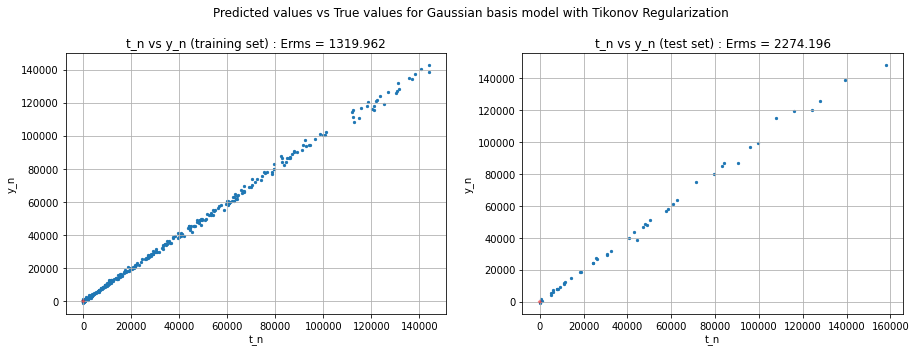

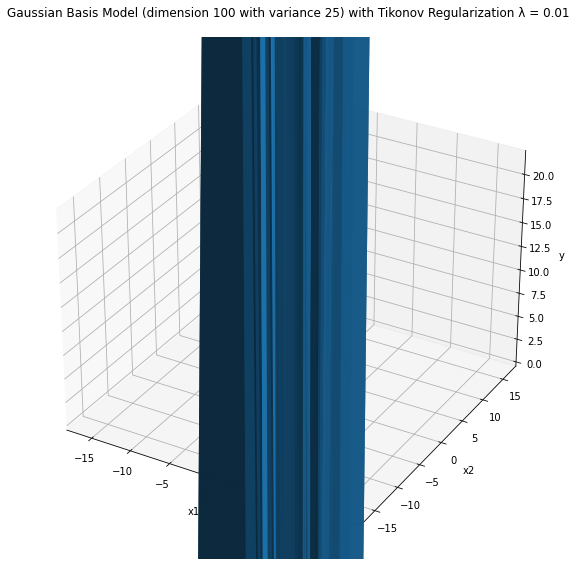

In [35]:
# Gaussian Basis Model with Tikhonov Regularization.
x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
w, means, x1, x2, y = gaussian_basis_fit(100, x_tr500, y_tr500, 25, 0.01, tikhonov=True)

x_ax = np.linspace(6, 24, 200)
erms, y_pred_train = Erms_gaussian(x_tr500, y_tr500, w, means, 25)
plt.figure(figsize=(15,5))
plt.suptitle("Predicted values vs True values for Gaussian basis model with Tikonov Regularization")
plt.subplot(121)
plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
plt.scatter(y_tr500, y_pred_train, s=5)
plt.xlabel('t_n'); plt.ylabel('y_n')
plt.title("t_n vs y_n (training set) : Erms = "+str(round(erms,3)))
plt.grid()

erms, y_pred_test = Erms_gaussian(x_test500, y_test500, w, means, 25)
plt.subplot(122)
plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
plt.scatter(y_test500, y_pred_test, s=5)
plt.xlabel('t_n'); plt.ylabel('y_n')
plt.title("t_n vs y_n (test set) : Erms = "+str(round(erms,3)))
plt.grid()

plt.subplots_adjust(top=0.85)
plt.show()

print("")
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plot_2d(ax, x_tr500, y_tr500, x1, x2, y, "Gaussian Basis Model (dimension 100 with variance 25) with Tikonov Regularization λ = 0.01", 0.2)
plt.subplots_adjust(top=0.85)
plt.show()

In [39]:
# Creating a table for deciding on type of regularization
# and the respective regularisation constant.
# x_train, y_train, x_test, y_test = train_test_split(X,Y,2000)
df = pd.DataFrame(np.zeros((8,4)))
df = df.astype({0: 'str'})
x_train = x_tr500
y_train = y_tr500
x_test = x_test500
y_test = y_test500
deg =100
sigma2 = 25
K = 5
# Using means from last cell
# means = kmeans(x_train, deg)
for tikn in [False, True]:
    for (i,rlambda) in enumerate([0,0.001,0.01,0.1]):
        df.iloc[4*tikn+i,0] = ("Tikhonov " if tikn else "")+"Regularization λ = "+str(rlambda)

        train_errors = []
        cv_errors = []

        x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
        for k in range(K):
            #print(means.shape)
            w, _means, x1, x2, y = gaussian_basis_fit(deg, x_train_sets[k], y_train_sets[k], sigma2, rlambda, tikhonov=tikn, predefined_means=means)
            #print(_means.shape)
            train_errors.append(Erms_gaussian(x_train_sets[k], y_train_sets[k], w, means, sigma2)[0])
            cv_errors.append(Erms_gaussian(x_valid_sets[k], y_valid_sets[k], w, means, sigma2)[0])

        df.iloc[4*tikn+i,1] = np.mean(train_errors)
        df.iloc[4*tikn+i,2] = np.mean(cv_errors)

        w, _means, x1, x2, y = gaussian_basis_fit(deg, x_train, y_train, sigma2, rlambda, tikhonov=tikn, predefined_means=means)
        df.iloc[4*tikn+i,3],_ = Erms_gaussian(x_test, y_test, w, means, sigma2)
    

df.rename(columns={0:"", 1:"Training Error", 2:"Validation Error", 3:"Test Set Error"}, inplace=True)
df.set_index("", inplace=True)
df

IndexError: index 51 is out of bounds for axis 0 with size 51

# Dataset 3

In [41]:
# Reading the Dataset 3
df = pd.read_csv("2_music.csv", header=None)
X = np.array(df[range(68)]); Y1 = np.array(df[[68]]); Y2 = np.array(df[[69]])
print("Input shape", X.shape)
print("Output1 shape", Y1.shape)
print("Output2 shape", Y2.shape)

Input shape (1059, 68)
Output1 shape (1059, 1)
Output2 shape (1059, 1)


In [47]:
# looking at the different values present in the 
# last 2 columns of the Dataset.
df1 = df.groupby([69,68]).size().to_frame()
coords = list(df1.index)
origins = np.array(coords)

d = {}; i=0
for coord in coords:
    if(coord in d):
        continue
    d[coord] = i
    i+=1

labels = []
for i in range(df.shape[0]):
    labels.append(d[(df.iloc[i][69], df.iloc[i][68])])
Y = np.array(labels).reshape(-1,1)
df2 = df.copy()
df2['label'] = labels
df2[[68,69,'label']].head()

KeyError: 69

## Report Observations for Dataset3

In [44]:
# Generating Tables for different values for 
# number of clusters and calculating Training, validation and Test error
x_train, y_train, x_test, y_test = train_test_split(X,Y1,X.shape[0])
df = pd.DataFrame(np.zeros((7,4)))
df = df.astype({0: 'str'})
sigma2 = 250
rlambda = 0
K = 5
# Using means from last cell
# means,_ = kmeans(x_train, deg)
for (i,deg) in enumerate([15,25,50,100,150,200,250]):
    df.iloc[i,0] = str(deg)+" clusters"
    sigma2 = 10*find_sigma(x_train, deg)
    train_errors = []
    cv_errors = []

    x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
    for k in range(K):
        w, means = gaussian_basis_fit(deg, x_train_sets[k], y_train_sets[k], sigma2, rlambda, tikhonov='tikn')
        train_errors.append(Erms_gaussian(x_train_sets[k], y_train_sets[k], w, means, sigma2)[0])
        cv_errors.append(Erms_gaussian(x_valid_sets[k], y_valid_sets[k], w, means, sigma2)[0])

    df.iloc[i,1] = np.mean(train_errors)
    df.iloc[i,2] = np.mean(cv_errors)

    w, means = gaussian_basis_fit(deg, x_train, y_train, sigma2, rlambda, tikhonov='tikn')
    df.iloc[i,3],_ = Erms_gaussian(x_test, y_test, w, means, sigma2)
    

df.rename(columns={0:"", 1:"Training (lat)", 2:"Validation (lat)", 3:"Test Set (lat)"}, inplace=True)
df.set_index("", inplace=True)
df

,Training (lat),Validation (lat),Test Set (lat)
,,,
15 clusters,16.767665,17.138565,17.893666
25 clusters,16.501596,17.065440,17.636172
50 clusters,15.427551,16.482427,16.385213
100 clusters,14.298953,16.469699,15.336778
150 clusters,13.331025,16.337343,15.522990
200 clusters,12.741211,16.780929,15.397501
250 clusters,11.817804,17.057317,15.599609


In [22]:
# # Generating tables to decide upon the type of regularisation 
# # and the respective regularisation constant.
# x_train, y_train, x_test, y_test = train_test_split(X,Y2,X.shape[0])
# df = pd.DataFrame(np.zeros((8,4)))
# df = df.astype({0: 'str'})
# deg = 100
# sigma2 = 250
# K = 5
# # Using means from last cell
# means,_ = kmeans(x_train, deg)
# for tikn in [False, True]:
#     for (i,rlambda) in enumerate([0,0.01,0.1,1]):
#         df.iloc[4*tikn+i,0] = ("Tikhonov " if tikn else "Quadratic ")+"Regularization λ = "+str(rlambda)

#         train_errors = []
#         cv_errors = []

#         x_train_sets, y_train_sets, x_valid_sets, y_valid_sets = k_cross_sets(x_train, y_train, K)
#         for k in range(K):
#             #print(means.shape)
#             w, _means = gaussian_basis_fit(deg, x_train_sets[k], y_train_sets[k], sigma2, rlambda, tikhonov=tikn, predefined_means=means)
#             #print(_means.shape)
#             train_errors.append(Erms_gaussian(x_train_sets[k], y_train_sets[k], w, means, sigma2)[0])
#             cv_errors.append(Erms_gaussian(x_valid_sets[k], y_valid_sets[k], w, means, sigma2)[0])

#         df.iloc[4*tikn+i,1] = np.mean(train_errors)
#         df.iloc[4*tikn+i,2] = np.mean(cv_errors)

#         w, means = gaussian_basis_fit(deg, x_train, y_train, sigma2, rlambda, tikhonov=tikn, predefined_means=means)
#         df.iloc[4*tikn+i,3],_ = Erms_gaussian(x_test, y_test, w, means, sigma2)
    

# df.rename(columns={0:"", 1:"Training (long)", 2:"Validation (long)", 3:"Test (long)"}, inplace=True)
# df.set_index("", inplace=True)
# df

In [23]:
# # Plotting Predicted values vs True values for Gaussian basis model with 
# # Tikonov Regularization for Longitude
# x_train, y_train, x_test, y_test = train_test_split(X,Y2,X.shape[0])
# w, means = gaussian_basis_fit(100, x_train, y_train, 250, 0.1, tikhonov=True)

# x_ax = np.linspace(np.min(y_train), np.max(y_train), 200)
# erms, y_pred_train = Erms_gaussian(x_train, y_train, w, means, 250)
# plt.figure(figsize=(15,5))
# plt.suptitle("Predicted values vs True values for Gaussian basis model with Tikonov Regularization for Longitude")
# plt.subplot(121)
# plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
# plt.xlabel('t_n'); plt.ylabel('y_n')
# plt.scatter(y_train, y_pred_train, s=5)
# plt.title("t_n vs y_n (training set) : Erms = "+str(round(erms,3)))
# plt.grid()

# x_ax = np.linspace(np.min(y_test), np.max(y_test), 200)
# erms, y_pred_test = Erms_gaussian(x_test, y_test, w, means, 250)
# plt.subplot(122)
# plt.plot(x_ax, x_ax, "red", linewidth=3, alpha=0.5)
# plt.xlabel('t_n'); plt.ylabel('y_n')
# plt.scatter(y_test, y_pred_test,  s=5)
# plt.title("t_n vs y_n (test set) : Erms = "+str(round(erms,3)))
# plt.grid()

# plt.subplots_adjust(top=0.85)
# plt.show()

## Trying to round off values

In [24]:
# x_train, y_train, x_test, y_test = train_test_split(X,Y1,X.shape[0])
# w, means = gaussian_basis_fit(deg, x_train, y_train, sigma2, 0.1, True)
# train_error, lat_pred = Erms_gaussian(x_train, y_train, w, means, sigma2)
# lat = y_train.copy()

# x_train, y_train, x_test, y_test = train_test_split(X,Y2,X.shape[0])
# w, means = gaussian_basis_fit(deg, x_train, y_train, sigma2, 0.1, True)
# train_error, long_pred = Erms_gaussian(x_train, y_train, w, means, sigma2)
# lon = y_train.copy()


# coords_pred = np.c_[long_pred, lat_pred]
# labels_pred = np.apply_along_axis(lambda row : np.argmin(np.sum((origins-row)**2,1)), 1, coords_pred)
# labels_actual = []
# for i in range(lat.shape[0]):
#     labels_actual.append(d[(lon[i,0], lat[i,0])])
# labels_actual = np.array(labels_actual)
# print("Correctly predicted locations out of 953 points in training set :")
# 953-np.count_nonzero(labels_actual-labels_pred)

## Maximum Likelihood trial

In [25]:
# x_train, y_train, x_test, y_test = train_test_split(X,Y,X.shape[0])

# def MLE(x, y):
#     l = np.max(y)+1
#     x_class = [None]*l
#     means = [None]*l
#     covariance_matrices = [None]*l
#     p_y = [0]*l
    
#     for i in range(x.shape[0]):
#         j = y[i,0]
#         if(x_class[j] is None):
#             x_class[j] = x[i]
#         else:
#             x_class[j] = np.vstack([x_class[j], x[i]])
#     for i in range(l):
#         means[i] = np.mean(x_class[i],0).reshape(1,-1)
#         covariance_matrices[i] = np.zeros((x.shape[1], x.shape[1]))
#         for j in range(x_class[i].shape[0]):
#             diff = (x_class[i][j]-means[i])**2
#             # tmp = np.matmul(diff.T, diff)
#             for k in range(x_class[i].shape[1]):
#                 covariance_matrices[i][k][k] = covariance_matrices[i][k][k] + diff[0,k]
#         covariance_matrices[i] = covariance_matrices[i]/x_class[i].shape[0]
        
#         p_y[i] = x_class[i].shape[0]/x.shape[0]

#     return p_y, means, covariance_matrices

# # In process
# def MLE_error(x, y, p_y, means, covariance_matrices):
#     for i in range(len(p_y)):
#         gaus_func = multivariate_normal(means[i].reshape(-1), covariance_matrices[i])
#         print(gaus_func.pdf(x[1]))

# p_y, means, covariance_matrices = MLE(x_train, y_train)
# np.linalg.det(covariance_matrices[2])
# # MLE_error(x_train, y_train, p_y, means, covariance_matrices)

## KNN Trial

In [26]:
# x_train, y_train, x_test, y_test = train_test_split(X,Y,Y.shape[0])
# neigh = KNeighborsClassifier(n_neighbors=7)
# neigh.fit(x_train, y_train.reshape(-1))

# a = 0
# for i in range(x_train.shape[0]):
#     a += 1 if (neigh.predict(x_train[i,:].reshape(1,-1))[0] - y_train[i]) == 0 else 0
# print("Training Accuracy : ",a,"/", x_train.shape[0])

# a = 0
# for i in range(x_test.shape[0]):
#     a+= 1 if (neigh.predict(x_test[i,:].reshape(1,-1))[0] - y_test[i]) == 0 else 0
# print("Test Accuracy : ",a,"/", x_test.shape[0])